# Session 5: Statistical Inference II - Non-Parametric Tests

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

1. Understand why non-parametric tests are valuable for event studies
2. Implement sign tests and generalized sign tests
3. Apply rank-based tests (Corrado, Corrado-Zivney)
4. Use bootstrap methods for inference
5. Compare parametric and non-parametric approaches

## 1. Introduction: Why Non-Parametric Tests?

Parametric tests assume normality, but returns are often:
- **Fat-tailed**: More extreme values than normal
- **Skewed**: Asymmetric distribution
- **Contain outliers**: Single observations can distort means

Non-parametric tests are:
- **Distribution-free**: No normality assumption
- **Robust to outliers**: Based on ranks or signs
- **Valid in small samples**: Exact distributions available

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from datetime import timedelta
from dataclasses import dataclass
from typing import List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded!")

Libraries loaded!


In [2]:
# Sample events
EVENTS = [
    {'ticker': 'AAPL', 'date': '2023-08-03', 'name': 'Apple Q3'},
    {'ticker': 'MSFT', 'date': '2023-07-25', 'name': 'Microsoft Q4'},
    {'ticker': 'GOOGL', 'date': '2023-07-25', 'name': 'Alphabet Q2'},
    {'ticker': 'AMZN', 'date': '2023-08-03', 'name': 'Amazon Q2'},
    {'ticker': 'META', 'date': '2023-07-26', 'name': 'Meta Q2'},
    {'ticker': 'NVDA', 'date': '2023-08-23', 'name': 'Nvidia Q2'},
    {'ticker': 'TSLA', 'date': '2023-07-19', 'name': 'Tesla Q2'},
    {'ticker': 'AMD', 'date': '2023-08-01', 'name': 'AMD Q2'},
    {'ticker': 'INTC', 'date': '2023-07-27', 'name': 'Intel Q2'},
    {'ticker': 'CRM', 'date': '2023-08-30', 'name': 'Salesforce Q2'},
]

EST_WINDOW, GAP, PRE, POST = 120, 10, 10, 10
WINDOWS = [(-1, +1), (0, 0), (-5, +5), (-10, +10)]

In [3]:
@dataclass
class EventResult:
    ticker: str
    model_sigma: float
    model_n_obs: int
    model_market_mean: float
    model_market_var: float
    event_data: pd.DataFrame
    estimation_data: pd.DataFrame

def process_event(ticker, event_date, est_window, gap, pre, post):
    """Download and process single event."""
    try:
        event_dt = pd.to_datetime(event_date)
        start = event_dt - timedelta(days=int((est_window + gap + pre) * 1.5))
        end = event_dt + timedelta(days=int(post * 2.5))
        
        stock = yf.download(ticker, start=start, end=end, progress=False)['Close']
        market = yf.download('^GSPC', start=start, end=end, progress=False)['Close']
        
        df = pd.DataFrame({'stock': stock.squeeze(), 'market': market.squeeze()})
        df['stock_ret'] = df['stock'].pct_change()
        df['market_ret'] = df['market'].pct_change()
        df = df.dropna()
        
        if event_dt not in df.index:
            idx = df.index.get_indexer([event_dt], method='nearest')[0]
            event_dt = df.index[idx]
        
        event_idx = df.index.get_loc(event_dt)
        df['event_time'] = range(-event_idx, len(df) - event_idx)
        
        est_end = -(gap + pre)
        est_data = df[(df['event_time'] >= est_end - est_window) & (df['event_time'] < est_end)].copy()
        evt_data = df[(df['event_time'] >= -pre) & (df['event_time'] <= post)].copy()
        
        # Market model
        y, x = est_data['stock_ret'].values, est_data['market_ret'].values
        X = sm.add_constant(x)
        ols = sm.OLS(y, X).fit()
        
        est_data['AR'] = est_data['stock_ret'] - (ols.params[0] + ols.params[1] * est_data['market_ret'])
        evt_data['AR'] = evt_data['stock_ret'] - (ols.params[0] + ols.params[1] * evt_data['market_ret'])
        
        return EventResult(
            ticker=ticker, model_sigma=np.std(ols.resid, ddof=2),
            model_n_obs=len(y), model_market_mean=np.mean(x),
            model_market_var=np.sum((x - np.mean(x))**2),
            event_data=evt_data, estimation_data=est_data
        )
    except Exception as e:
        print(f"{ticker}: FAILED - {e}")
        return None

print("Processing events...")
event_results = [r for e in EVENTS if (r := process_event(e['ticker'], e['date'], EST_WINDOW, GAP, PRE, POST))]
print(f"Processed {len(event_results)} events")

Processing events...
YF.download() has changed argument auto_adjust default to True
Processed 10 events


In [7]:
def calculate_car(event_data, tau1, tau2):
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    return event_data.loc[mask, 'AR'].sum()

## 2. Examining Return Distributions

Distribution of Estimation Period Residuals:
  Skewness: 1.564
  Kurtosis: 15.605 (excess)
  Jarque-Bera p-value: 0.0000


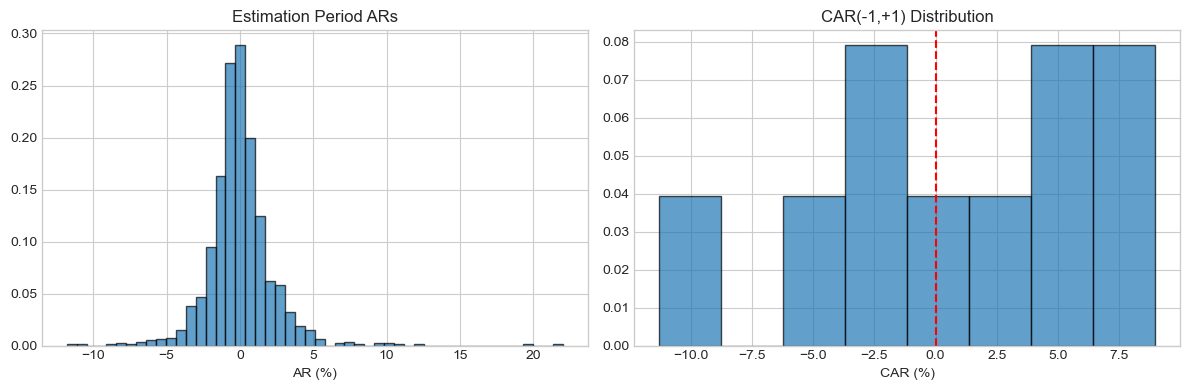

In [10]:
all_ars = np.concatenate([r.estimation_data['AR'].values for r in event_results])
cars_11 = np.array([calculate_car(r.event_data, -1, 1) for r in event_results])

print("Distribution of Estimation Period Residuals:")
print(f"  Skewness: {stats.skew(all_ars):.3f}")
print(f"  Kurtosis: {stats.kurtosis(all_ars):.3f} (excess)")
jb_stat, jb_p = stats.jarque_bera(all_ars)
print(f"  Jarque-Bera p-value: {jb_p:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(all_ars*100, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title('Estimation Period ARs')
axes[0].set_xlabel('AR (%)')
axes[1].hist(cars_11*100, bins=8, density=True, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('CAR(-1,+1) Distribution')
axes[1].set_xlabel('CAR (%)')
plt.tight_layout()
plt.show()

## 3. Sign Test

Tests if proportion of positive CARs exceeds 0.5:

$$Z_{sign} = \frac{N^+ - 0.5N}{\sqrt{0.25N}}$$

In [26]:
def sign_test(event_results, tau1, tau2):
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    N = len(cars)
    N_pos = np.sum(cars > 0)
    Z = (N_pos - 0.5 * N) / np.sqrt(0.25 * N)
    p_exact = stats.binomtest(N_pos, N, 0.5)
    return {'N': N, 'N_pos': N_pos, 'prop_pos': N_pos/N, 'Z': Z, 'p_value': p_exact, 'CAAR': np.mean(cars)}

print("Sign Test Results:")
print("="*60)
for tau1, tau2 in WINDOWS:
    r = sign_test(event_results, tau1, tau2)
    r['p_value'] = r['p_value'].pvalue
    sig = '***' if r['p_value'] < 0.01 else '**' if r['p_value'] < 0.05 else '*' if r['p_value'] < 0.10 else ''
    print(f"[{tau1:+d},{tau2:+d}]: {r['N_pos']}/{r['N']} positive ({r['prop_pos']*100:.0f}%), Z={r['Z']:+.3f}, p={r['p_value']:.4f} {sig}")

Sign Test Results:
[-1,+1]: 5/10 positive (50%), Z=+0.000, p=1.0000 
[+0,+0]: 8/10 positive (80%), Z=+1.897, p=0.1094 
[-5,+5]: 6/10 positive (60%), Z=+0.632, p=0.7539 
[-10,+10]: 3/10 positive (30%), Z=-1.265, p=0.3438 


## 4. Generalized Sign Test (Cowan, 1992)

Uses estimation period to estimate baseline P(AR > 0):

$$Z_{GST} = \frac{N^+ - N \cdot \hat{p}}{\sqrt{N \cdot \hat{p} \cdot (1 - \hat{p})}}$$

In [28]:
def generalized_sign_test(event_results, tau1, tau2):
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    N = len(cars)
    
    # Estimate p_hat from estimation periods
    p_hat = np.mean([np.mean(r.estimation_data['AR'].values > 0) for r in event_results])
    
    N_pos = np.sum(cars > 0)
    expected = N * p_hat
    Z = (N_pos - expected) / np.sqrt(N * p_hat * (1 - p_hat))
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    return {'N': N, 'N_pos': N_pos, 'p_hat': p_hat, 'expected': expected, 'Z': Z, 'p_value': p_value}

print("\nGeneralized Sign Test Results:")
print("="*60)
p_hat = np.mean([np.mean(r.estimation_data['AR'].values > 0) for r in event_results])
print(f"Estimated baseline P(AR>0) = {p_hat:.3f}")
for tau1, tau2 in WINDOWS:
    r = generalized_sign_test(event_results, tau1, tau2)
    sig = '***' if r['p_value'] < 0.01 else '**' if r['p_value'] < 0.05 else '*' if r['p_value'] < 0.10 else ''
    print(f"[{tau1:+d},{tau2:+d}]: {r['N_pos']}/{r['N']} vs {r['expected']:.1f} expected, Z={r['Z']:+.3f}, p={r['p_value']:.4f} {sig}")


Generalized Sign Test Results:
Estimated baseline P(AR>0) = 0.466
[-1,+1]: 5/10 vs 4.7 expected, Z=+0.217, p=0.8285 
[+0,+0]: 8/10 vs 4.7 expected, Z=+2.118, p=0.0341 **
[-5,+5]: 6/10 vs 4.7 expected, Z=+0.851, p=0.3950 
[-10,+10]: 3/10 vs 4.7 expected, Z=-1.051, p=0.2931 


## 5. Corrado (1989) Rank Test

Ranks ARs across estimation + event period, then transforms:

$$K_{i,t} = \frac{rank(AR_{i,t})}{T + 1} - 0.5$$

In [30]:
def corrado_rank_test(event_results, tau1, tau2):
    N = len(event_results)
    transformed_ranks = []
    all_K = []
    
    for r in event_results:
        all_ars = np.concatenate([r.estimation_data['AR'].values, r.event_data['AR'].values])
        T = len(all_ars)
        ranks = stats.rankdata(all_ars, method='average')
        K = ranks / (T + 1) - 0.5
        
        all_K.extend(K[:len(r.estimation_data)])
        
        evt_K = K[len(r.estimation_data):]
        mask = (r.event_data['event_time'].values >= tau1) & (r.event_data['event_time'].values <= tau2)
        transformed_ranks.append(np.mean(evt_K[mask]))
    
    K_bar = np.mean(transformed_ranks)
    S_K = np.std(all_K, ddof=1) / np.sqrt(N)
    Z = K_bar / S_K if S_K > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    return {'N': N, 'mean_rank': K_bar, 'Z': Z, 'p_value': p_value}

print("\nCorrado (1989) Rank Test Results:")
print("="*60)
for tau1, tau2 in WINDOWS:
    r = corrado_rank_test(event_results, tau1, tau2)
    sig = '***' if r['p_value'] < 0.01 else '**' if r['p_value'] < 0.05 else '*' if r['p_value'] < 0.10 else ''
    print(f"[{tau1:+d},{tau2:+d}]: Mean Rank={r['mean_rank']:+.4f}, Z={r['Z']:+.3f}, p={r['p_value']:.4f} {sig}")


Corrado (1989) Rank Test Results:
[-1,+1]: Mean Rank=+0.0486, Z=+0.534, p=0.5936 
[+0,+0]: Mean Rank=+0.1296, Z=+1.423, p=0.1547 
[-5,+5]: Mean Rank=-0.0071, Z=-0.078, p=0.9378 
[-10,+10]: Mean Rank=-0.0359, Z=-0.394, p=0.6935 


## 6. Wilcoxon Signed-Rank Test

Tests whether median CAR differs from zero, considering both sign and magnitude.

In [32]:
def wilcoxon_test(event_results, tau1, tau2):
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    stat, p_value = stats.wilcoxon(cars, alternative='two-sided')
    return {'N': len(cars), 'median': np.median(cars), 'W': stat, 'p_value': p_value}

print("\nWilcoxon Signed-Rank Test Results:")
print("="*60)
for tau1, tau2 in WINDOWS:
    r = wilcoxon_test(event_results, tau1, tau2)
    sig = '***' if r['p_value'] < 0.01 else '**' if r['p_value'] < 0.05 else '*' if r['p_value'] < 0.10 else ''
    print(f"[{tau1:+d},{tau2:+d}]: Median={r['median']*100:+.3f}%, W={r['W']:.1f}, p={r['p_value']:.4f} {sig}")


Wilcoxon Signed-Rank Test Results:
[-1,+1]: Median=+1.084%, W=22.0, p=0.6250 
[+0,+0]: Median=+0.819%, W=12.0, p=0.1309 
[-5,+5]: Median=+1.747%, W=25.0, p=0.8457 
[-10,+10]: Median=-6.296%, W=10.0, p=0.0840 *


## 7. Bootstrap Test

Resamples events to construct empirical distribution of CAAR.

In [34]:
def bootstrap_test(event_results, tau1, tau2, n_boot=5000):
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    N = len(cars)
    caar = np.mean(cars)
    
    np.random.seed(42)
    boot_caars = [np.mean(cars[np.random.choice(N, N, replace=True)]) for _ in range(n_boot)]
    boot_caars = np.array(boot_caars)
    
    boot_se = np.std(boot_caars)
    ci_lower, ci_upper = np.percentile(boot_caars, [2.5, 97.5])
    p_value = np.mean(np.abs(boot_caars - caar) >= np.abs(caar))
    t_stat = caar / boot_se if boot_se > 0 else 0
    
    return {'N': N, 'CAAR': caar, 'boot_SE': boot_se, 't': t_stat, 
            'CI_lower': ci_lower, 'CI_upper': ci_upper, 'p_value': p_value, 'distribution': boot_caars}

print("\nBootstrap Test Results (B=5000):")
print("="*70)
boot_results = []
for tau1, tau2 in WINDOWS:
    r = bootstrap_test(event_results, tau1, tau2)
    boot_results.append(r)
    sig = '***' if r['p_value'] < 0.01 else '**' if r['p_value'] < 0.05 else '*' if r['p_value'] < 0.10 else ''
    print(f"[{tau1:+d},{tau2:+d}]: CAAR={r['CAAR']*100:+.3f}%, 95% CI=[{r['CI_lower']*100:+.2f}%,{r['CI_upper']*100:+.2f}%], t={r['t']:+.3f}, p={r['p_value']:.4f} {sig}")


Bootstrap Test Results (B=5000):
[-1,+1]: CAAR=+0.959%, 95% CI=[-2.93%,+4.52%], t=+0.501, p=0.6256 
[+0,+0]: CAAR=+0.599%, 95% CI=[-0.12%,+1.33%], t=+1.638, p=0.1018 
[-5,+5]: CAAR=-0.761%, 95% CI=[-4.71%,+2.95%], t=-0.390, p=0.6946 
[-10,+10]: CAAR=-5.226%, 95% CI=[-9.97%,-0.74%], t=-2.204, p=0.0262 **


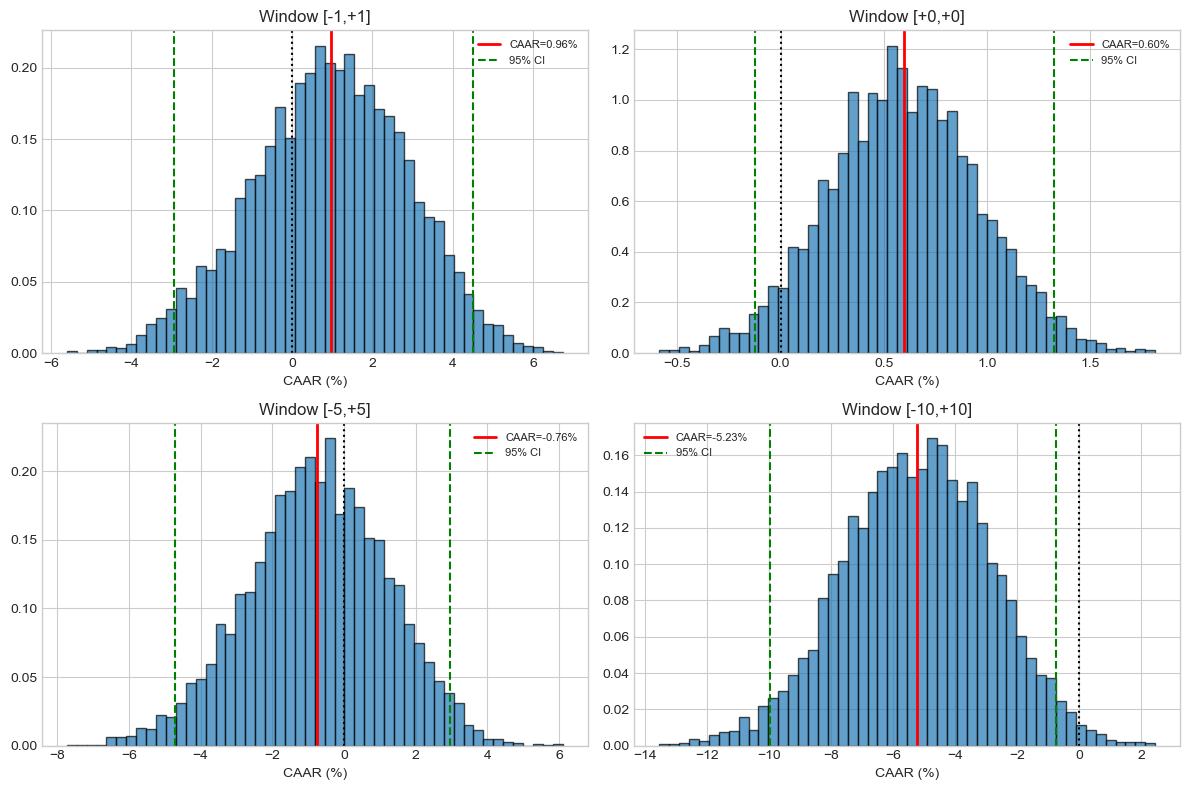

In [36]:
# Visualize bootstrap distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ((tau1, tau2), r) in enumerate(zip(WINDOWS, boot_results)):
    ax = axes.flatten()[i]
    ax.hist(r['distribution']*100, bins=50, density=True, alpha=0.7, edgecolor='black')
    ax.axvline(r['CAAR']*100, color='red', lw=2, label=f'CAAR={r["CAAR"]*100:.2f}%')
    ax.axvline(r['CI_lower']*100, color='green', ls='--', label='95% CI')
    ax.axvline(r['CI_upper']*100, color='green', ls='--')
    ax.axvline(0, color='black', ls=':')
    ax.set_title(f'Window [{tau1:+d},{tau2:+d}]')
    ax.set_xlabel('CAAR (%)')
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 8. Comprehensive Test Comparison

In [40]:
# Add parametric tests for comparison
def t_test(event_results, tau1, tau2):
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    N = len(cars)
    t_stat = np.mean(cars) / (np.std(cars, ddof=1) / np.sqrt(N))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=N-1))
    return {'t': t_stat, 'p': p_value}

print("\n" + "="*100)
print("COMPREHENSIVE TEST COMPARISON")
print("="*100)

for tau1, tau2 in WINDOWS:
    cars = [calculate_car(r.event_data, tau1, tau2) for r in event_results]
    print(f"\nWindow [{tau1:+d},{tau2:+d}]: CAAR={np.mean(cars)*100:+.3f}%, Median={np.median(cars)*100:+.3f}%")
    print("-"*80)
    
    tt = t_test(event_results, tau1, tau2)
    st = sign_test(event_results, tau1, tau2)
    gst = generalized_sign_test(event_results, tau1, tau2)
    cr = corrado_rank_test(event_results, tau1, tau2)
    wt = wilcoxon_test(event_results, tau1, tau2)
    bt = bootstrap_test(event_results, tau1, tau2, n_boot=2000)
    
    def sig(p): return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
    
    results = [
        ('t-test (Param)', tt['t'], tt['p']),
        ('Sign Test', st['Z'], st['p_value'].pvalue),
        ('Gen. Sign Test', gst['Z'], gst['p_value']),
        ('Corrado Rank', cr['Z'], cr['p_value']),
        ('Wilcoxon', np.nan, wt['p_value']),
        ('Bootstrap', bt['t'], bt['p_value']),
    ]
    
    for name, stat, p in results:
        stat_str = f"{stat:+.3f}" if not np.isnan(stat) else "  N/A"
        print(f"  {name:18s}: stat={stat_str}, p={p:.4f} {sig(p)}")


COMPREHENSIVE TEST COMPARISON

Window [-1,+1]: CAAR=+0.959%, Median=+1.084%
--------------------------------------------------------------------------------
  t-test (Param)    : stat=+0.475, p=0.6459 
  Sign Test         : stat=+0.000, p=1.0000 
  Gen. Sign Test    : stat=+0.217, p=0.8285 
  Corrado Rank      : stat=+0.534, p=0.5936 
  Wilcoxon          : stat=  N/A, p=0.6250 
  Bootstrap         : stat=+0.496, p=0.6320 

Window [+0,+0]: CAAR=+0.599%, Median=+0.819%
--------------------------------------------------------------------------------
  t-test (Param)    : stat=+1.550, p=0.1556 
  Sign Test         : stat=+1.897, p=0.1094 
  Gen. Sign Test    : stat=+2.118, p=0.0341 **
  Corrado Rank      : stat=+1.423, p=0.1547 
  Wilcoxon          : stat=  N/A, p=0.1309 
  Bootstrap         : stat=+1.649, p=0.0970 *

Window [-5,+5]: CAAR=-0.761%, Median=+1.747%
--------------------------------------------------------------------------------
  t-test (Param)    : stat=-0.367, p=0.7223 
  

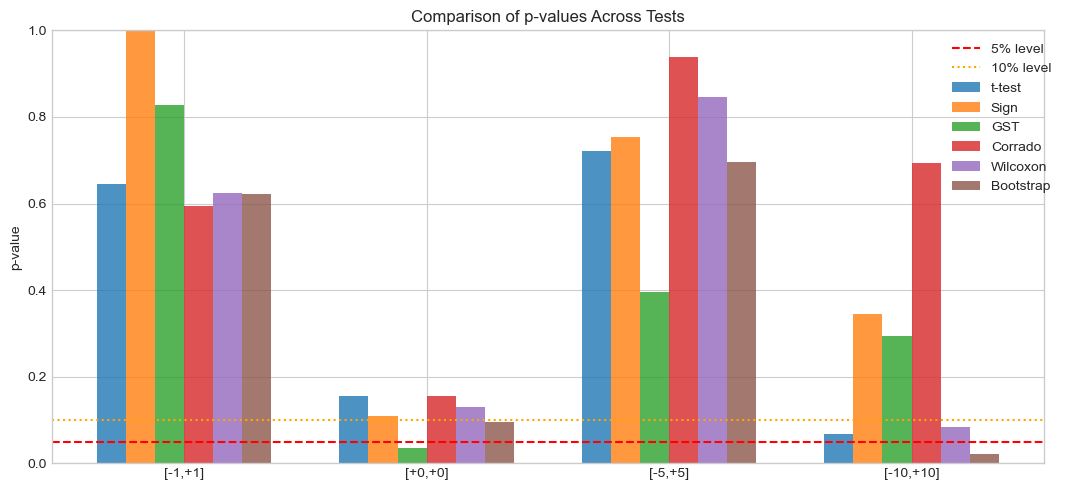

In [44]:
# Compare p-values visually
fig, ax = plt.subplots(figsize=(12, 5))

test_names = ['t-test', 'Sign', 'GST', 'Corrado', 'Wilcoxon', 'Bootstrap']
x = np.arange(len(WINDOWS))
width = 0.12

for j, name in enumerate(test_names):
    p_vals = []
    for tau1, tau2 in WINDOWS:
        if name == 't-test':
            p_vals.append(t_test(event_results, tau1, tau2)['p'])
        elif name == 'Sign':
            p_vals.append(sign_test(event_results, tau1, tau2)['p_value'].pvalue)
        elif name == 'GST':
            p_vals.append(generalized_sign_test(event_results, tau1, tau2)['p_value'])
        elif name == 'Corrado':
            p_vals.append(corrado_rank_test(event_results, tau1, tau2)['p_value'])
        elif name == 'Wilcoxon':
            p_vals.append(wilcoxon_test(event_results, tau1, tau2)['p_value'])
        else:
            p_vals.append(bootstrap_test(event_results, tau1, tau2, 1000)['p_value'])
    ax.bar(x + j*width, p_vals, width, label=name, alpha=0.8)

ax.axhline(0.05, color='red', ls='--', label='5% level')
ax.axhline(0.10, color='orange', ls=':', label='10% level')
ax.set_xticks(x + 2.5*width)
ax.set_xticklabels([f'[{t1:+d},{t2:+d}]' for t1, t2 in WINDOWS])
ax.set_ylabel('p-value')
ax.set_title('Comparison of p-values Across Tests')
ax.legend(bbox_to_anchor=(1.02, 1))
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 9. Monte Carlo: Size and Power

In [50]:
def monte_carlo_power(N_events, N_sims, true_car, skewness=0, alpha=0.05):
    """Monte Carlo for test size/power."""
    rejections = {'t': 0, 'sign': 0, 'wilcoxon': 0}
    
    for _ in range(N_sims):
        if skewness == 0:
            cars = np.random.normal(true_car, 0.05, N_events)
        else:
            cars = stats.skewnorm.rvs(skewness, loc=true_car, scale=0.05, size=N_events)
        
        _, t_p = stats.ttest_1samp(cars, 0)
        if t_p < alpha: rejections['t'] += 1
        
        sign_p = stats.binomtest(np.sum(cars > 0), N_events, 0.5).pvalue
        if sign_p < alpha: rejections['sign'] += 1
        
        try:
            _, wilc_p = stats.wilcoxon(cars)
            if wilc_p < alpha: rejections['wilcoxon'] += 1
        except: pass
    
    return {k: v/N_sims for k, v in rejections.items()}

print("Monte Carlo Analysis (N=30, 500 sims):")
print("="*50)

print("\n1. SIZE (CAR=0, Normal):")
size = monte_carlo_power(30, 500, 0, 0)
for t, r in size.items(): print(f"   {t}: {r*100:.1f}%")

print("\n2. SIZE (CAR=0, Skewed):")
size_skew = monte_carlo_power(30, 500, 0, 3)
for t, r in size_skew.items(): print(f"   {t}: {r*100:.1f}%")

print("\n3. POWER (CAR=1%):")
power = monte_carlo_power(30, 500, 0.01, 0)
for t, r in power.items(): print(f"   {t}: {r*100:.1f}%")

Monte Carlo Analysis (N=30, 500 sims):

1. SIZE (CAR=0, Normal):
   t: 4.0%
   sign: 4.0%
   wilcoxon: 4.4%

2. SIZE (CAR=0, Skewed):
   t: 100.0%
   sign: 100.0%
   wilcoxon: 100.0%

3. POWER (CAR=1%):
   t: 18.2%
   sign: 12.6%
   wilcoxon: 19.0%


## 10. Practical Guidelines

| Test | Use When | Strengths |
|------|----------|----------|
| **Sign Test** | Quick check, any sample | Simple, no distribution assumption |
| **Generalized Sign** | Skewed returns | Accounts for baseline asymmetry |
| **Corrado Rank** | Fat tails, outliers | Robust to extreme values |
| **Wilcoxon** | Test median ≠ 0 | Uses magnitude information |
| **Bootstrap** | Unknown distribution | Flexible, provides CI |

**Recommended**: Report parametric (BMP) + non-parametric (Corrado or Bootstrap) for robustness.

In [52]:
# Publication table
print("\n" + "="*90)
print("PUBLICATION TABLE")
print("="*90)

def sig(p): return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

rows = []
for tau1, tau2 in WINDOWS:
    cars = [calculate_car(r.event_data, tau1, tau2) for r in event_results]
    tt = t_test(event_results, tau1, tau2)
    gst = generalized_sign_test(event_results, tau1, tau2)
    cr = corrado_rank_test(event_results, tau1, tau2)
    
    rows.append({
        'Window': f'[{tau1:+d},{tau2:+d}]',
        'N': len(cars),
        'CAAR': f"{np.mean(cars)*100:+.2f}%",
        'Median': f"{np.median(cars)*100:+.2f}%",
        '%Pos': f"{np.mean(np.array(cars)>0)*100:.0f}%",
        't-stat': f"{tt['t']:.2f}{sig(tt['p'])}",
        'GST': f"{gst['Z']:.2f}{sig(gst['p_value'])}",
        'Rank': f"{cr['Z']:.2f}{sig(cr['p_value'])}"
    })

print(pd.DataFrame(rows).to_string(index=False))
print("\nNotes: ***, **, * = 1%, 5%, 10% significance")


PUBLICATION TABLE
   Window  N   CAAR Median %Pos t-stat    GST  Rank
  [-1,+1] 10 +0.96% +1.08%  50%   0.48   0.22  0.53
  [+0,+0] 10 +0.60% +0.82%  80%   1.55 2.12**  1.42
  [-5,+5] 10 -0.76% +1.75%  60%  -0.37   0.85 -0.08
[-10,+10] 10 -5.23% -6.30%  30% -2.08*  -1.05 -0.39

Notes: ***, **, * = 1%, 5%, 10% significance


## 11. Summary

**Key Takeaways:**

1. **Non-parametric tests** are robust to non-normality
2. **Sign tests** are simple but may lack power
3. **Rank tests** (Corrado) handle outliers well
4. **Bootstrap** provides flexible inference and confidence intervals
5. **Use multiple tests** for robustness

**Next Session:** Cross-Sectional Analysis and Multi-Firm Studies

## References

- Cowan, A. R. (1992). Nonparametric event study tests. *Review of Quantitative Finance and Accounting*, 2(4), 343-358.
- Corrado, C. J. (1989). A nonparametric test for abnormal security-price performance. *Journal of Financial Economics*, 23(2), 385-395.
- Corrado, C. J., & Zivney, T. L. (1992). The specification and power of the sign test in event study hypothesis tests. *Journal of Financial and Quantitative Analysis*, 27(3), 465-478.